# Importing libaries

In [16]:
#data processing and importing
import pandas as pd
import numpy as np
import csv
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib as plt

#label encoder
from sklearn import preprocessing

#text transformation via spacy and keras 
import spacy
from keras.layers import TextVectorization
from tensorflow.keras import utils

#lstm model 
from keras import backend as K
from tensorflow.keras.models import Sequential 
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

***

# Importing and preparing the data

*Importing raw data*

In [17]:
#import speeches for 2021 as sample
speeches_df = pd.read_csv('data/speeches_new.csv')
speeches_df.columns

Index(['id', 'session', 'electoralTerm', 'firstName', 'lastName',
       'politicianId', 'speechContent', 'factionId', 'documentUrl',
       'positionShort', 'positionLong', 'date'],
      dtype='object')

In [18]:
#import faction id 
faction_df = pd.read_csv('data/factions.csv')
faction_df = faction_df.rename(columns={'id':'factionId'})

In [19]:
#merging the two dataframes
data = pd.merge(left = speeches_df, right = faction_df, on = 'factionId', how = 'inner')

In [20]:
#dropping all columns that are not needed
data = data[['speechContent', 'abbreviation']]
data.rename(columns={'abbreviation':'partie'}, inplace=True)

In [21]:
#expecting the value count of all columns 
data.partie.value_counts()

not found     4195
CDU/CSU       1086
SPD            704
FDP            558
AfD            545
Grüne          544
DIE LINKE.     486
Name: partie, dtype: int64

In [22]:
#removing not found
data = data[data.partie != 'not found']

*DataFrame of imported data*

In [23]:
#adding a column "string_length" to the DataFrame
data[['string_length']]= data['speechContent'].str.len()
data.groupby('partie').count()

,speechContent,string_length
partie,,
AfD,545,545
CDU/CSU,1086,1086
DIE LINKE.,486,486
FDP,558,558
Grüne,544,544
SPD,704,704


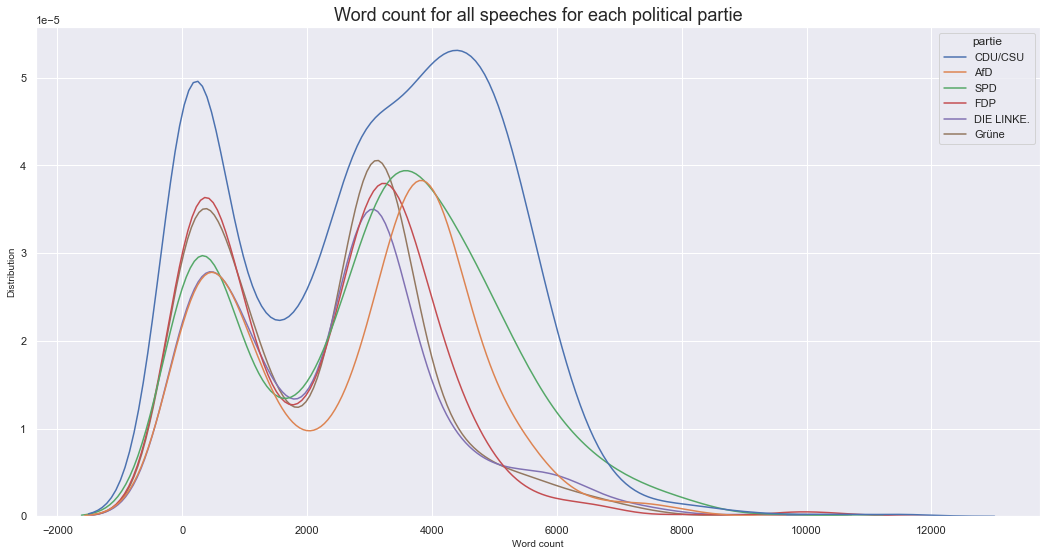

In [24]:
##distribution plot before reducing the amount of speeches
sns.set_theme(style="whitegrid", palette = "Set2")
sns.set(rc = {'figure.figsize':(18,9)})
sns.kdeplot(data=data, x="string_length", hue = 'partie')
plt.pyplot.title(label = 'Word count for all speeches for each political partie', size = 18)
plt.pyplot.xlabel(xlabel = 'Word count', size = 10)
plt.pyplot.ylabel(ylabel = 'Distribution', size = 10);

In [25]:
#reducing the amount of data
data = data.loc[data['string_length'] >= 5000]
data.groupby('partie').count()

,speechContent,string_length
partie,,
AfD,49,49
CDU/CSU,192,192
DIE LINKE.,38,38
FDP,20,20
Grüne,30,30
SPD,115,115


In [26]:
#creating small samples of speeches, for each political party only 50 
max_number_speeches = 13

cdu_csu = data[data['partie'] == 'CDU/CSU'][:max_number_speeches]
spd = data[data['partie'] == 'SPD'][:max_number_speeches]
fdp = data[data['partie'] == 'FDP'][:max_number_speeches]
afd = data[data['partie'] == 'AfD'][:max_number_speeches]
gruene = data[data['partie'] == 'Grüne'][:max_number_speeches]
linke = data[data['partie'] == 'DIE LINKE.'][:max_number_speeches]

data = pd.concat([cdu_csu, spd, fdp, afd, gruene, linke], ignore_index=True)
data.groupby('partie').count()

,speechContent,string_length
partie,,
AfD,13,13
CDU/CSU,13,13
DIE LINKE.,13,13
FDP,13,13
Grüne,13,13
SPD,13,13


*Checking the length of the speeches*

In [27]:
#checking the minimal length of a speech 
min_length = int(data['speechContent'].str.len().min()) #The int() method returns an integer object from any number or string
print(f'The minimal length of one speech is {min_length}.')

The minimal length of one speech is 5046.


In [28]:
#checking the maximial length of a speech 
max_length = int(data['speechContent'].str.len().max()) #The int() method returns an integer object from any number or string
print(f'The maximal length of one speech is {max_length}.')

The maximal length of one speech is 10512.


In [29]:
#checking the length of the median for all speeches
median_length = int(data['speechContent'].str.len().median()) #The int() method returns an integer object from any number or string
print(f'The length of the median for all speeches is {median_length}.')

The length of the median for all speeches is 5946.


In [30]:
#checking the average length of a speech 
mean_length = int(data['speechContent'].str.len().mean())
print(f'The length of the mean for all speeches is {mean_length}.')

The length of the mean for all speeches is 6286.


***

# Preprocessing the speeches (X)

Remarks: Since I want to include grammatical information in my model’s input vectors, I don’t want to remove stopwords or lemmatize words. Also, as capitilazation is very crucial in the German language, I did not lower the single words. I only removed special characters via RegEx, did vectorizing via word embedding and padding. 

*RegEx*

In [31]:
#defining X_series and y_series
X_series = data['speechContent']
y_series = data['partie']

In [32]:
#examining X_series
X_series.head()

0    \n\nHerr Präsident! Meine Damen! Meine Herren!...
1    \n\nHerr Präsident! Liebe Kolleginnen und Koll...
2    \n\nFrau Präsidentin! Liebe Kolleginnen und Ko...
3    \n\nHerzlichen Dank. – Frau Präsidentin! Sehr ...
4    \n\nSehr geehrte Frau Präsidentin! Liebe Kolle...
Name: speechContent, dtype: object

In [33]:
#cleaning the speeches using regex
X_series = X_series.str.replace('\n',' ', regex = True) #removes all newlines 
X_series = X_series.str.replace('\xa0',' ', regex = True) #removes all \xa0
X_series = X_series.str.replace(',',' ', regex = True) #removes all commas
X_series = X_series.str.replace('?',' ', regex = True) #removes all ?
X_series = X_series.str.replace('!',' ', regex = True) #removes all !
X_series = X_series.str.replace('.',' ', regex = True) #removes all .
X_series = X_series.str.replace('–',' ', regex = True) #removes all -
X_series = X_series.str.replace(':',' ', regex = True) #removes all :
X_series = X_series.str.replace(';',' ', regex = True) #removes all ;
X_series = X_series.str.replace('„',' ', regex = True) #removes all „
X_series = X_series.str.replace('“',' ', regex = True) #removes all “
X_series = X_series.str.replace('/',' ', regex = True) #removes all /
X_series = X_series.str.replace('\b\d+\b', '', regex = True) #removes all digits
X_series = X_series.str.replace(r"\(.*\)"," ") #removes brackets and everything that is inside of it
X_series = X_series.str.replace(r"\[.*\]"," ") #removes squared brackets and everything that is inside of it

/var/folders/n_/f0kktvdx00s93tvvh3xlcch40000gn/T/ipykernel_76144/3620408096.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  X_series = X_series.str.replace(r"\(.*\)"," ") #removes brackets and everything that is inside of it
/var/folders/n_/f0kktvdx00s93tvvh3xlcch40000gn/T/ipykernel_76144/3620408096.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  X_series = X_series.str.replace(r"\[.*\]"," ") #removes squared brackets and everything that is inside of it


In [34]:
#final check-up
len(X_series)              #checking if the length of the list is still 1200 
X_series[8]                #expecting single speeches for check-up

'  Frau Präsidentin  Meine sehr geehrten Damen und Herren  Ob es nun ein nachträgliches Weihnachtsgeschenk für die Europäer war oder ob es für die Chinesen ein vorgezogenes Geschenk zum chinesischen Neujahrsfest war  das kann man nun unterschiedlich bewerten  Auf jeden Fall war der Abschluss des Investitionsabkommens zwischen der Europäischen Union und China am 30  Dezember noch mal ein großer Erfolg für Europa und für die deutsche Ratspräsidentschaft  meine Damen und Herren    '

***

*Tokens*

In [35]:
#cleaning the keras sessions
K.clear_session()

In [36]:
#loading spacy & text vectorization
nlp = spacy.load('de_core_news_md')                             #loading the German word embedding from spacy with a vector length of 300
Vectorizer = TextVectorization(output_sequence_length=6000)      #keras.TextVectorization with a truncating / padding of 6000 as it seems to be good size for a speech (mode is 5673)

In [37]:
#fit the vectorizer on the text and extract the corpus vocabulary
Vectorizer.adapt(X_series)          #training the Vectorizer on the speeches
vocab = Vectorizer.get_vocabulary() #retrieving and tokenizing the unique vocabulary 
vocab[5]                            #inspecting the first tokens

'in'

In [38]:
#how many tokens (single words) are there?
num_token= len(vocab) 
print(f'The Vectorizer produced {num_token} unique tokenized words.')

The Vectorizer produced 2797 unique tokenized words.


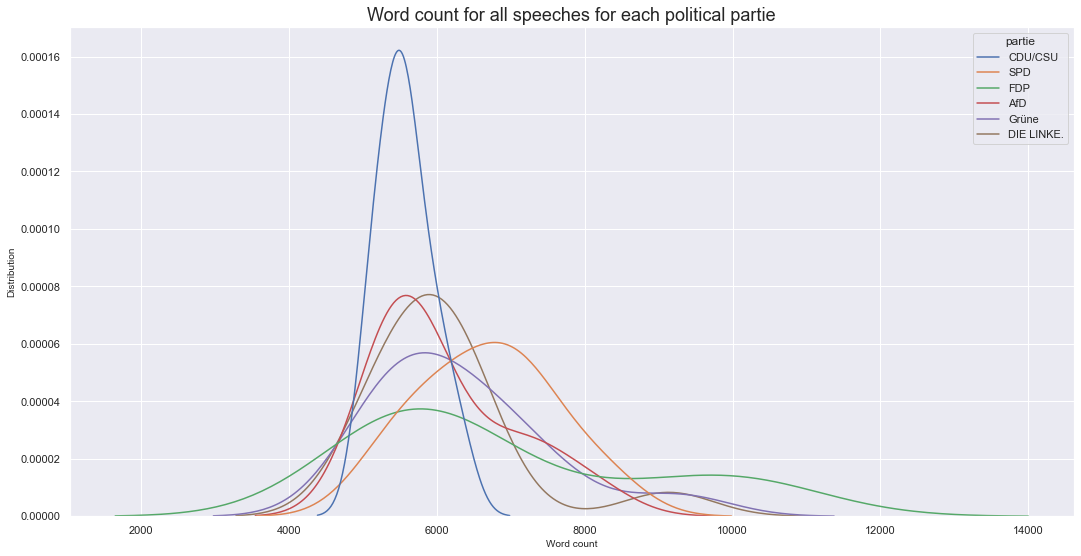

In [39]:
#distribution plot after reducing the amount of speeches
sns.set_theme(style="whitegrid", palette = "Set2")
sns.set(rc = {'figure.figsize':(18,9)})
sns.kdeplot(data=data, x="string_length", hue = 'partie')
plt.pyplot.title(label = 'Word count for all speeches for each political partie', size = 18)
plt.pyplot.xlabel(xlabel = 'Word count', size = 10)
plt.pyplot.ylabel(ylabel = 'Distribution', size = 10);

***

*Embedding matrix*

In [40]:
#observing and saving the length of one vector
embedding_dim = len(nlp('test').vector)
embedding_dim

300

In [41]:
#creating an empty embedding matrix in the size of num_tokens & embedding_dim
embedding_matrix = np.zeros((num_token, embedding_dim)) #15300 unique words & 300 length of vector
embedding_matrix.shape              

(2797, 300)

In [42]:
#check: the embedding matrix should be a completely empty scaffolding
embedding_matrix[1] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [43]:
#mapping the empty embedding matrix to the nlp word vector
for i, word in enumerate(vocab):
    embedding_matrix[i] = nlp(str(word)).vector

#check: the embedding matrix should be filled with vectors
embedding_matrix[1]

***

# Preprocessing the labels (y)

In [ ]:
#transforming the parties into labels 
le = preprocessing.LabelEncoder()
le.fit(y_series)
labels = le.transform(y_series) #the names of the political parties are transformed into numbers in [0,1,2,3,4,5]
labels

In [ ]:
#one_hot_encoding of labels
y = utils.to_categorical(labels, num_classes=6)
y.shape

In [ ]:
#testing if the labels & one-hot-encoding of the labels worked
labels[:5] , y[:5]  #yes, it worked!

***

# Building the LSTM model

input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words. <br><br>
output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem. <br><br>
input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = num_token, output_dim = embedding_dim, input_length=6000, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)) #trainable = False, for this layer not trained - also good against overfitting
model.add(LSTM(5))                          #first start small, than max up the number
model.add(Dense(6, activation='softmax'))   #softmax activation, last layer should have 6 neurons as there are 6 parties
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

***

# Fitting the LSTM model

In [ ]:
#fit the model
model.fit(X, y, batch_size = 50, epochs = 50)